In [86]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path as op
import seaborn as sns
from math import pow
from sklearn.preprocessing import OneHotEncoder

In [2]:
#videos = pd.read_parquet(op.join("df_metadata_sample_clean.parquet.gzip"), engine="fastparquet")
videos = pd.read_parquet("df_metadata_sample_clean.parquet.gzip", engine="pyarrow")
#videos = pd.read_csv('df_metadata_sample_Pace.csv')

videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,13,49.0,🎤 Check out these links! 🎤\nhttp://patreon.com...,[7] Ace Combat 7: Skies Unknown w/ GaLm
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,8,19.0,Hey friends it's me KaOs Broly I hope you enjo...,Splatoon - New Piranha Pit Map Gameplay
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,2,0.0,For more videos click | http://goo.gl/6NU4DG\n...,Haryanvi Krishan Bhajan Sri Radhe Govinda Jug ...
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,1,0.0,A new ice cream shop in North Texas is turning...,New ice cream shop turning dessert into a fine...


## Define virality

In [100]:
#log scale to adapt to the distributions
#Theoretical try :
#videos['virality']=np.log(videos['view_count']+1)/np.log(videos['subs_before_video']+1)

#Empirical ajustment : it looks like -log(.), so by taking exp(-.) we obtain a line.
#Note that now virality is generally in [0,1]
videos['virality']=1-np.exp(-np.log(videos['view_count']+1)/np.log(videos['subs_before_video']+1))

#Now we add an affine function to get a straight line : we want a max* virality of 1 for 10 subs and same for 10M subs
#*max of "visible cloud of points"
sparsity=2.1 #Becomes harder to approach 1 for high sparsity
videos['virality']=(0.055*np.log10(videos['subs_before_video'])-0.05+videos['virality'])**sparsity

(0.0, 2.0)

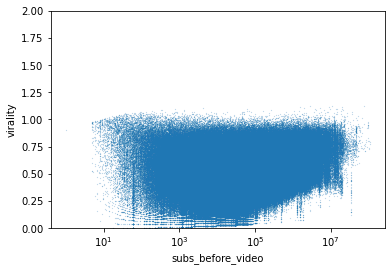

In [101]:
videos.plot.scatter(x='subs_before_video', y='virality',logx=True,s=0.01)
plt.ylim([0,2])

### Is our definition good ? Generally tends to decreases with number of subscribers

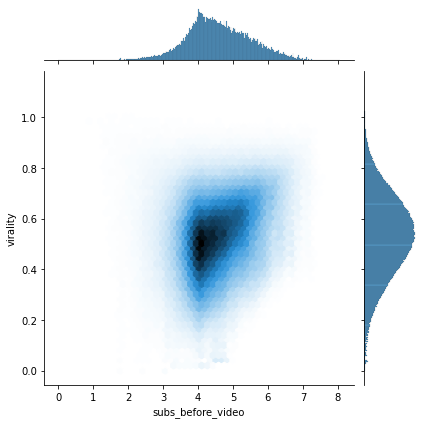

In [102]:
sns.jointplot(x=np.log10(videos['subs_before_video']), y=videos['virality'], kind="hex")


 ### Check normal distribution to use Linear Gaussian Model

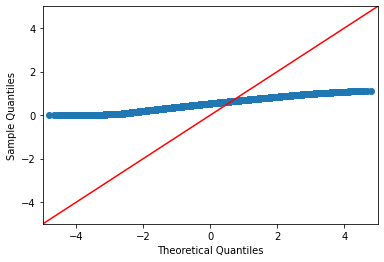

In [103]:
#select_group=videos[(videos['subs_before_video']>10**3) & (videos['subs_before_video']<10**5)]
#virality=select_group['virality']
virality=videos['virality']
#virality.hist(bins=100) Already in heat plot
#test normal distrib
import statsmodels.api as sm
import pylab

sm.qqplot(virality, line='45')
pylab.show()

### Underdispersion diagnostic : we can divide the output in different groups of viralities to transform it into count data, and use Negative Binomial regression model.

## Appreciation

In [4]:
#Like/dislike ratio
videos['like_ratio']=np.log(videos['like_count']+2)/np.log(videos['dislike_count']+2)

In [5]:
videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,tags_count,num_comms,description,title,virality,like_ratio
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,15,39.0,Send me your submissions to be featured https:...,Twitch Stream Fails and Epic Moments Compilati...,1.039202,1.646140
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,15,179.0,If Floyd Mayweather vs. Conor McGregor ends up...,Conor McGregor's Best Asset: Undermining Doubt...,1.037371,1.549693
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,8,0.0,Watch Srirastu Subhamastu telugu movie dailogu...,Srirastu Subhamastu Latest Teaser | Allu Siris...,0.795803,3.484980
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,41,125.0,COACHING & TRAINING PLANS\nVisit harryruns.com...,Interval Training: How To Become a Faster Runner,1.521678,1.664508
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,1,23.0,Now in theatres!,STALKER - Janus Films Trailer,0.758276,8.577429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,13,49.0,🎤 Check out these links! 🎤\nhttp://patreon.com...,[7] Ace Combat 7: Skies Unknown w/ GaLm,0.706752,4.123964
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,8,19.0,Hey friends it's me KaOs Broly I hope you enjo...,Splatoon - New Piranha Pit Map Gameplay,0.541604,2.578902
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,2,0.0,For more videos click | http://goo.gl/6NU4DG\n...,Haryanvi Krishan Bhajan Sri Radhe Govinda Jug ...,0.451085,1.000000
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,1,0.0,A new ice cream shop in North Texas is turning...,New ice cream shop turning dessert into a fine...,0.396753,1.000000


### Preprocess categories to fit Random Forest

In [6]:
onehot=OneHotEncoder()
encoded=onehot.fit_transform(videos[['categories']])
videos[onehot.categories_[0]]=encoded.toarray()
onehot.categories_[0]

array(['Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Sports',
       'Travel & Events', 'Unknown'], dtype=object)

In [7]:
videos

,index,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,subs_before_video,...,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Sports,Travel & Events,Unknown
0,676973,Gaming,UCrnftLporTV1YgYbVi7GFsw,31,TqLn2hX6zoA,655,314,2019-03-13,45868.0,30595.541667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66343748,Sports,UC2EuJ9xTs0XkDZI9YGx7QZA,51,MCEQL6g5EIU,614,468,2017-03-25,29088.0,20086.343750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12315685,Entertainment,UCiJfiEg1FImWsVuEu0L8X6Q,1,l3_IlJr-8_U,30,44,2016-08-18,11506.0,126756.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29036231,People & Blogs,UCVptfwYcLxRED8w4Efy0CsA,88,y126khD2Q5k,373,1788,2016-04-05,189885.0,2942.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,56543085,Film & Animation,UCAP57cF-FSjJKzzXg7ntPlQ,0,JCuwthnCRpg,120,380,2019-01-08,7559.0,130292.885417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257064,39977981,Gaming,UCN-Klifn9C7kINwpIA0uOHw,2,QhWTZppzqxI,1579,302,2019-02-11,7518.0,305116.869792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257065,71798200,Gaming,UCskB-HpWs7BAVPvjdJf9-6g,1,1DytQ27ZFCQ,743,15,2015-12-29,116.0,6585.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257066,35917598,Music,UCQEloCMWEZFep85nHfbbg8Q,0,wiP1xD1Tapc,389,0,2014-01-24,175.0,95064.375000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257067,54370862,People & Blogs,UCBu0KdNokE4MqdkacvH37_A,1,3qmjq0j3-zE,143,1,2019-01-18,55.0,25481.217593,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
## Delete columns to save memory

In [9]:
videos.dtypes

index                             int64
categories                     category
channel_id                       object
dislike_count                     int32
display_id                       object
duration                          int64
like_count                        int32
upload_date              datetime64[ns]
view_count                      float64
subs_before_video               float64
tags_count                        int64
num_comms                       float64
description                      object
title                            object
virality                        float64
like_ratio                      float64
Autos & Vehicles                float64
Comedy                          float64
Education                       float64
Entertainment                   float64
Film & Animation                float64
Gaming                          float64
Howto & Style                   float64
Music                           float64
News & Politics                 float64


In [10]:
videos.drop(['categories', 'channel_id','dislike_count','display_id','like_count','upload_date','description','title'], axis=1, inplace=True)

In [11]:
videos.dtypes

index                      int64
duration                   int64
view_count               float64
subs_before_video        float64
tags_count                 int64
num_comms                float64
virality                 float64
like_ratio               float64
Autos & Vehicles         float64
Comedy                   float64
Education                float64
Entertainment            float64
Film & Animation         float64
Gaming                   float64
Howto & Style            float64
Music                    float64
News & Politics          float64
Nonprofits & Activism    float64
People & Blogs           float64
Pets & Animals           float64
Science & Technology     float64
Sports                   float64
Travel & Events          float64
Unknown                  float64
dtype: object

### Random Forest

In [12]:
x=videos[['duration','subs_before_video','like_ratio','tags_count','Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Sports',
       'Travel & Events', 'Unknown']]
#we include subs before video because maybe a video is still more easily viral for big channels according to our definition
y=videos['virality']

In [13]:
# FITTING Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(x, y) 

RandomForestRegressor(n_estimators=10, random_state=0)

In [15]:
#from platform import python_version

In [16]:
#python_version()

In [96]:
#regressor.estimator_

In [94]:
#PREDICTION
virality_test=regressor.predict([[200, 100000, 1.2, 2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]])[0]

C:\Users\Utilisateur\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [95]:
predicted_views=np.exp(virality_test*np.log(100000))
predicted_views

364762.6747919234